In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np             
import pandas as pd   
import plotly.graph_objects as go
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession,SQLContext
from datetime import datetime
from pyspark.sql.types import IntegerType
import seaborn as sns
import re
from textblob import TextBlob
conf = SparkConf().setMaster("local").setAppName("Weather analysis")  
from sklearn.metrics import mean_squared_error      #for reading & storing data, pre-processing
pd.set_option('display.float_format', lambda x: '%.5f' % x)

sc = SparkContext(conf = conf)
spark = SparkSession(sc)

sqlContext = SQLContext(sc)


In [52]:
#Loading the dataset
data = spark.read.option("header",'true').csv("C:\\Users\\Administrator\\Downloads\\SampleData.csv",inferSchema=True)
print(data.dtypes)

[('Region', 'string'), ('Country', 'string'), ('State', 'string'), ('City', 'string'), ('Month', 'int'), ('Day', 'int'), ('Year', 'int'), ('AvgTemperature', 'double')]


In [53]:
#Data conversion into a pandas dataframe 
data=data.toPandas()

#Choosing only the rows with country name India from the dataframe
data_India  = data[ (data['Country'] == 'India') & (data['Year'] < 2020)]

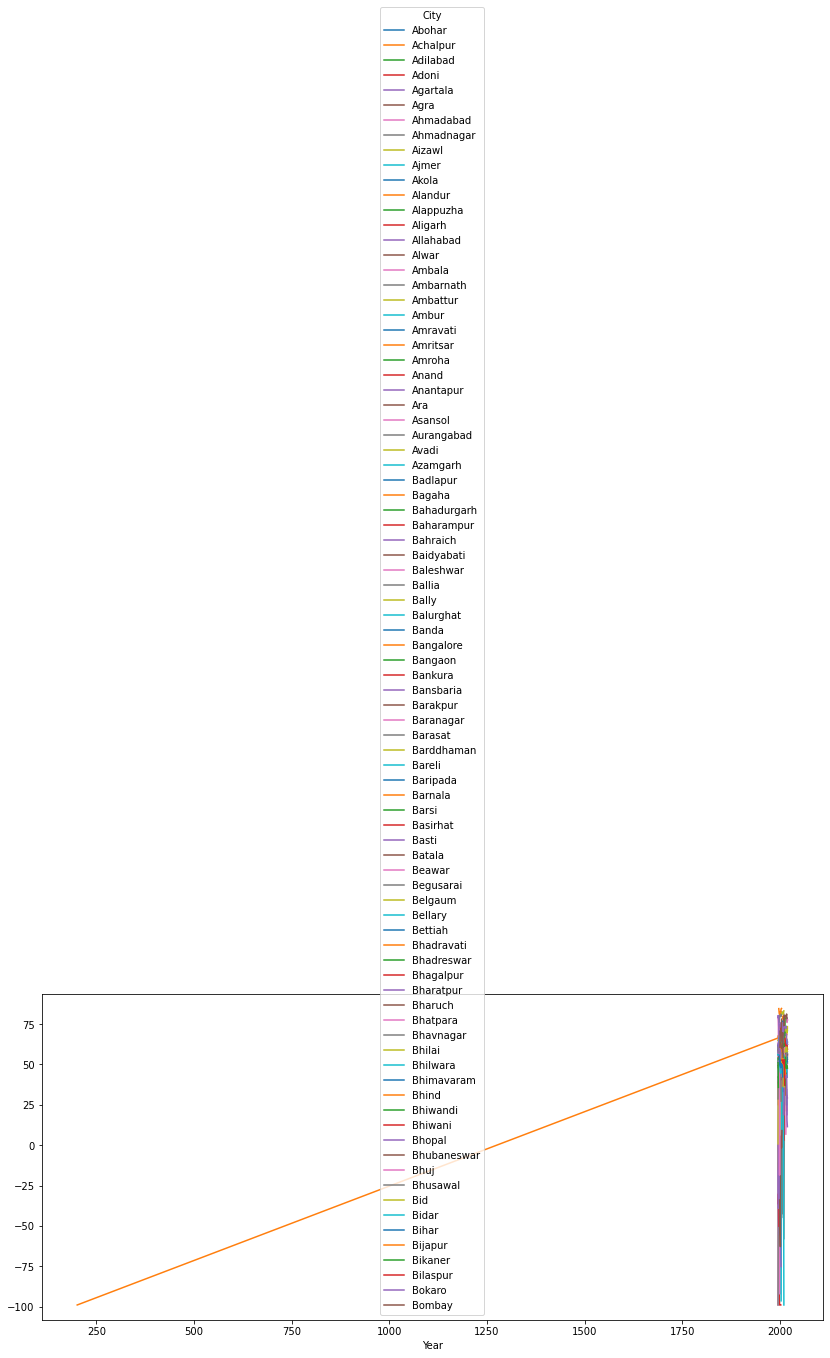

In [54]:
#plot for 4 cities and comparison of their temparatures
India_plot=data_India.groupby(['City','Year'])['AvgTemperature'].mean().reset_index()
India_plot.pivot('Year','City','AvgTemperature').plot()
plt.gcf().set_size_inches(14,6)
fig1= plt.savefig("C:\\Users\\Administrator\\Desktop\\Final Screenshots")
plt.show()


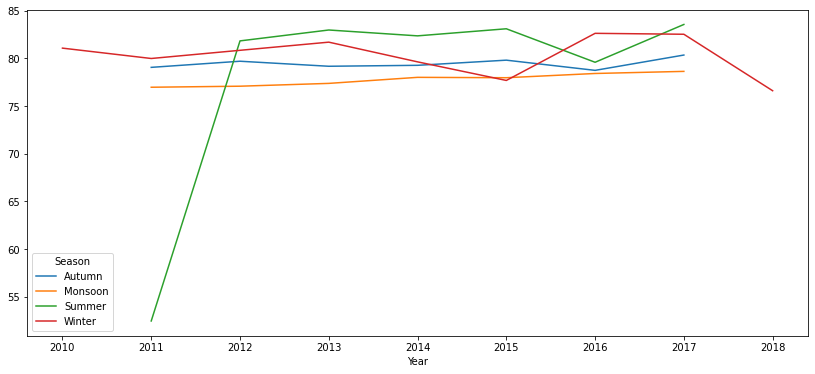

In [55]:
#creating variable called 'season'
def season(data):
    if data in [12,1,2] :
        return 'Winter'
    elif data in [3,4,5]:
        return 'Summer'
    elif data in [6,7,8]:
        return 'Monsoon'
    elif data in [9,10,11]:
        return 'Autumn'
    else:
        return 'NA'

pd.options.mode.chained_assignment = None  # default='warn'
data_India['Season'] = data_India['Month'].apply(season)

data_India['AvgTemperature']=data_India['AvgTemperature'].astype('float64')
data_India[['Month' , 'Day' , 'Year']]=data_India[['Month' , 'Day' , 'Year']].astype('int64')

#Seasons in Agra
data_Agra = data_India[data_India['City'] == 'Agra']

#Plot the seasons
Agra_plot=data_Agra.groupby(['Season','Year'])['AvgTemperature'].mean().reset_index()
Agra_plot.pivot('Year','Season','AvgTemperature').plot()
plt.gcf().set_size_inches(14,6)
fig2= plt.savefig("C:\\Users\\Administrator\\Desktop\\Final Screenshots")
plt.show()

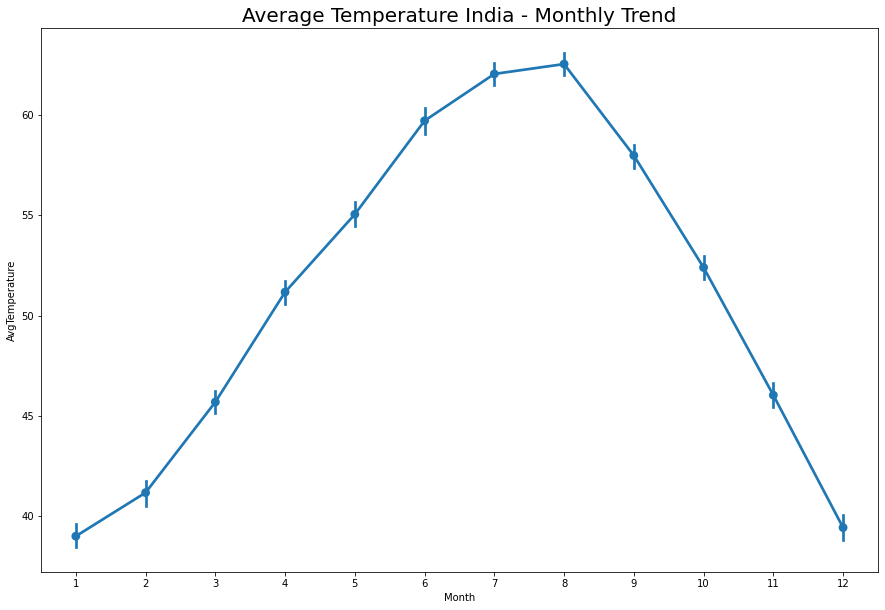

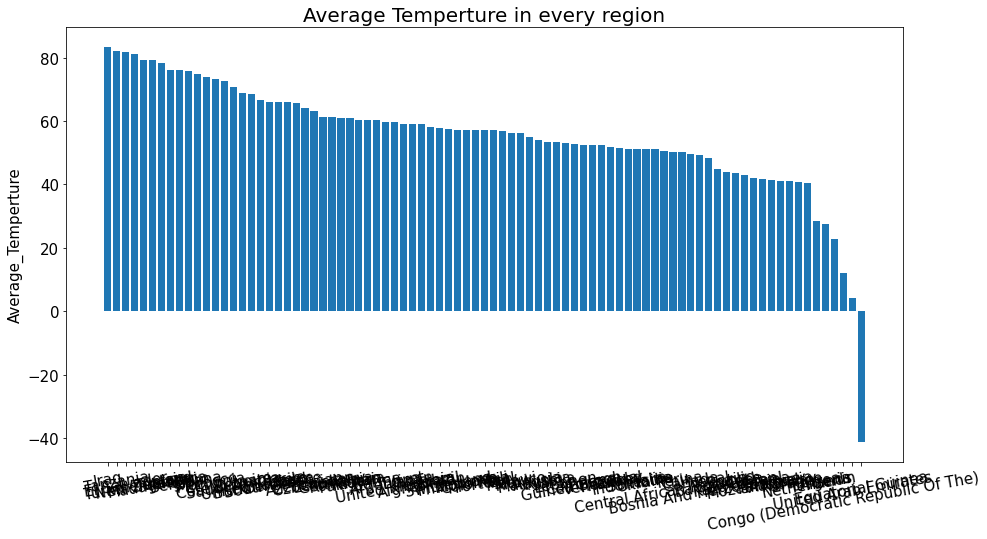

In [56]:
#Average temparature monthly in India
plt.figure(figsize= (15,10))
sns.pointplot(x='Month', y='AvgTemperature', data=data_India);
plt.title('Average Temperature India - Monthly Trend',fontsize=20);

avgtmp = data.groupby("Region")["AvgTemperature"].mean().sort_values()[-1::-1]
avgtmp = avgtmp.rename({"South/Central America & Carribean":"South America","Australia/South Pacific":"Australia"})
avgtmp

fig3= plt.figure(figsize = (15,8))
plt.bar(avgtmp.index,avgtmp.values)
plt.xticks(rotation = 10,size = 15)
plt.yticks(size = 15)
plt.ylabel("Average_Temperture",size = 15)
plt.title("Average Temperture in every region",size = 20)
fig3=plt.savefig("C:\\Users\\Administrator\\Desktop\\Final Screenshots")
plt.show()

In [57]:
#dropping the State column as it has many null values
data.drop('State',axis='columns', inplace=True)

#Keeping only rows for Agra
Agra = data[data["City"] == "Agra"]
Agra.reset_index(inplace = True)
Agra.drop('index', axis = 1, inplace=True)
print(Agra.describe())



           Month        Day       Year  AvgTemperature
count 2613.00000 2613.00000 2613.00000      2613.00000
mean     6.50555   15.77153 2014.01416        78.95216
std      3.50558    8.80216    2.06225        16.27064
min      1.00000    1.00000 2010.00000       -99.00000
25%      3.00000    8.00000 2012.00000        78.20000
50%      7.00000   16.00000 2014.00000        80.60000
75%     10.00000   23.00000 2016.00000        82.60000
max     12.00000   31.00000 2018.00000        86.90000


In [58]:
#Converting to datetime format
Agra['Date'] = pd.to_datetime(Agra[['Year','Month','Day']])
Agra = Agra.drop(['Region', 'Country', 'City','Month','Day'], axis = 1)
print(Agra.head())

   Year  AvgTemperature       Date
0  2010        77.20000 2010-12-09
1  2010        79.60000 2010-12-10
2  2010        80.50000 2010-12-11
3  2010        78.40000 2010-12-12
4  2010        82.20000 2010-12-13


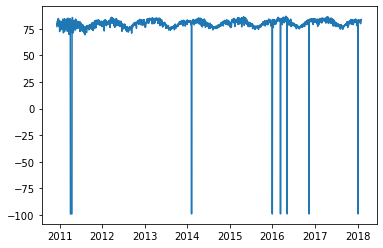

In [59]:
#Visualisation
fig4= plt.plot(Agra["Date"], Agra["AvgTemperature"])
fig4=plt.savefig("C:\\Users\\Administrator\\Desktop\\Final Screenshots")
plt.show()

In [72]:
#Defining training and testing data
training_set = Agra[Agra["Year"] <= 2018]
test_set = Agra[Agra["Year"] > 2015]


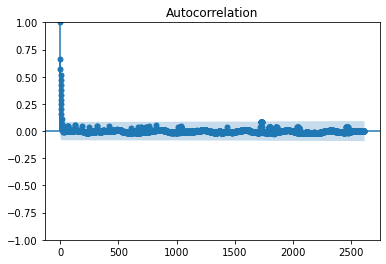

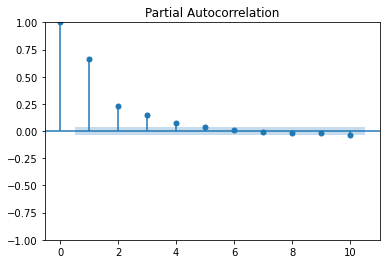

In [73]:
#acf and pacf plots
from statsmodels.graphics.tsaplots import plot_acf
acf=plot_acf(Agra["AvgTemperature"], lags = 2612)
from statsmodels.graphics.tsaplots import plot_pacf
pacf=plot_pacf(Agra["AvgTemperature"], lags = 10)
fig5=plt.savefig("C:\\Users\\Administrator\\Desktop\\Final Screenshots")
plt.show()


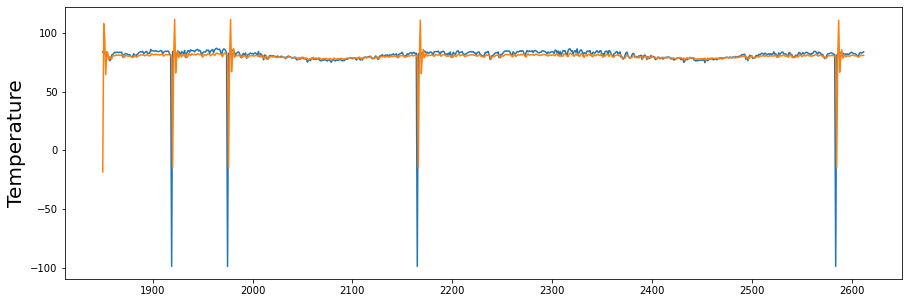

In [74]:
#MA model
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
import warnings

warnings.filterwarnings("ignore")
m1 = ARIMA(training_set["AvgTemperature"],order=(0,0,2))

m2 = m1.fit()

pred = m2.predict(test_set.index[0],test_set.index[-1])

fig5=plt.figure(figsize=(15,5))
plt.ylabel("Temperature",fontsize=20)
plt.plot(test_set["AvgTemperature"],label="Original Data")
plt.plot(pred,label="Predictions")
fig6=plt.savefig("C:\\Users\\Administrator\\Desktop\\Final Screenshots")
plt.show()
#plt.legend()

In [75]:
#RMSE for MA model
mse = mean_squared_error(pred,test_set["AvgTemperature"])
print(mse**0.5)

15.610242420398327


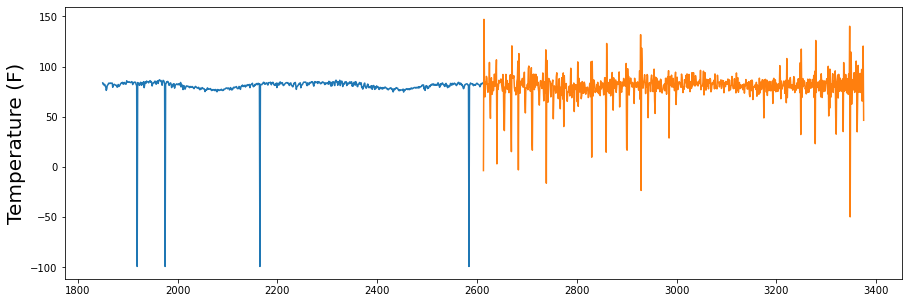

22.22734847865871


In [76]:
#AR model
from statsmodels.tsa.ar_model import AutoReg
model_AR = AutoReg(training_set["AvgTemperature"], lags = 800)
model_fit_AR = model_AR.fit()
predictions_AR = model_fit_AR.predict(training_set.shape[0], training_set.shape[0] + test_set.shape[0] - 1)
import seaborn as sns
fig6= plt.figure(figsize=(15,5))
plt.ylabel("Temperature (F)", fontsize = 20)
plt.plot(test_set["AvgTemperature"], label = "Original Data")
plt.plot(predictions_AR, label = "Predictions")
fig7=plt.savefig("C:\\Users\\Administrator\\Desktop\\Final Screenshots")
plt.show()

rmse = mean_squared_error(predictions_AR,test_set["AvgTemperature"])
print(rmse**0.5)

In [29]:
#Keeping only rows for the city "Agra"
import sys
print("City, Year, Month, Day, AvgTemperature")
for line in sys.stdin:
  line = line.strip()
  row = line.split(",")
  if row[3] == "Agra":
      print(row[3] + ',' + row[6] + ',' + row[4] +  ',' + row[5] + ',' + row[-1])

City, Year, Month, Day, AvgTemperature
